# Análise de Comportamento de Usuário - Sprint 11
Este notebook tem como objetivo analisar o comportamento dos usuários no aplicativo da empresa de produtos alimentícios, estudar o funil de eventos e avaliar os resultados de um teste A/A/B sobre mudanças na fonte do app.

# Índice do Projeto - Sprint 11

1. [Preparação dos Dados](#preparação-dos-dados)  
2. [Análise Geral dos Dados](#análise-geral-dos-dados)  
3. [Estudo do Funil de Eventos](#estudo-do-funil-de-eventos)  
4. [Análise do Funil de Vendas](#análise-do-funil-de-vendas)  
5. [Análise Inicial dos Grupos Experimentais](#análise-inicial-dos-grupos-experimentais)  
6. [Testes Estatísticos entre Grupos de Controle (A/A)](#testes-estatísticos-entre-grupos-de-controle-aa)  
7. [Comparação entre Grupo de Teste e Grupos de Controle (A/B)](#comparação-entre-grupo-de-teste-e-grupos-de-controle-ab)  
8. [Conclusões](#conclusões)


1. Importação de bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt

sns.set(style='whitegrid')


2. Carregamento e visualização inicial dos dados

In [2]:
# Carrega o arquivo CSV com separador tab
df = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

# Visualiza as 5 primeiras linhas
df.head()


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Renomeando colunas para facilitar o uso

In [3]:
df.columns = ['event', 'user_id', 'timestamp', 'exp_id']
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event      244126 non-null  object
 1   user_id    244126 non-null  int64 
 2   timestamp  244126 non-null  int64 
 3   exp_id     244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Conversão do timestamp para datetime e extração da data

In [4]:
# Converte o timestamp para datetime e cria nova coluna com a data
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = df['datetime'].dt.date

df.head()


,event,user_id,timestamp,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


# Preparação dos Dados

Neste bloco, realizamos os seguintes passos:

- Importamos as bibliotecas necessárias para análise e visualização
- Carregamos o arquivo CSV contendo os dados do experimento.
- Renomeamos as colunas para nomes mais simples e fáceis de usar.
- Verificamos se há valores ausentes e conferimos os tipos de dados.
- Convertimos a coluna `timestamp` para o formato datetime, facilitando manipulação de datas e horas.
- Criamos colunas separadas para data e hora, para análises específicas posteriores.
- Por fim, mostramos as primeiras linhas do dataset para conferência dos dados carregados.


3. Estatísticas básicas e verificação dos dados

In [5]:
# Quantidade total de eventos e usuários únicos
total_events = df.shape[0]
unique_users = df['user_id'].nunique()
events_per_user = total_events / unique_users

print(f'Total de eventos: {total_events}')
print(f'Usuários únicos: {unique_users}')
print(f'Média de eventos por usuário: {events_per_user:.2f}')


Total de eventos: 244126
Usuários únicos: 7551
Média de eventos por usuário: 32.33


Análise do período de dados disponíveis

In [6]:
print('Data mínima:', df['datetime'].min())
print('Data máxima:', df['datetime'].max())


Data mínima: 2019-07-25 04:43:36
Data máxima: 2019-08-07 21:15:17


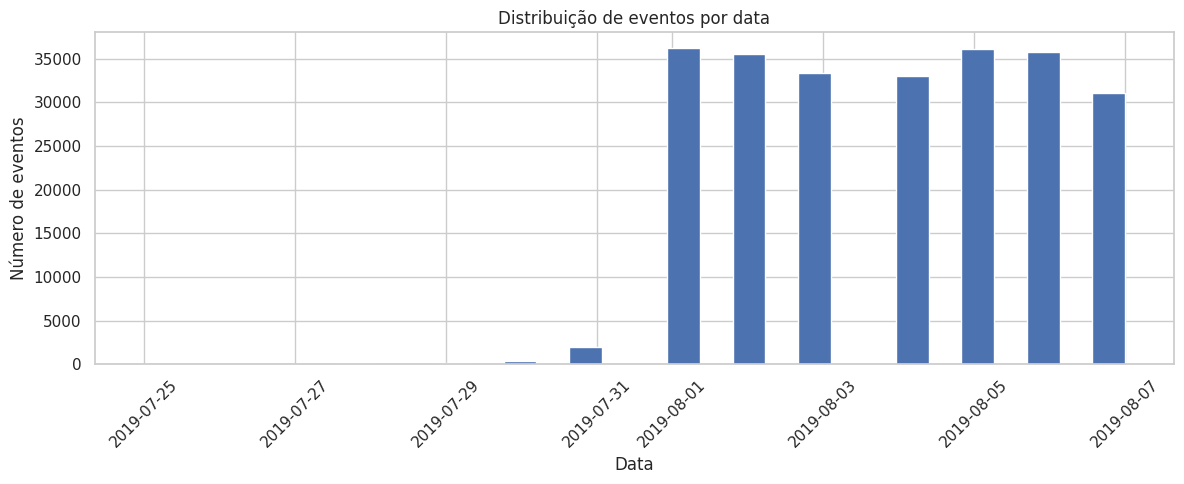

In [7]:
# Histograma 
df['date'] = pd.to_datetime(df['date']) 
plt.figure(figsize=(12,5))
df['date'].hist(bins=30)
plt.title('Distribuição de eventos por data')
plt.xlabel('Data')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Análise Geral dos Dados

- Calculamos o total de eventos registrados no dataset.
- Contamos o número de usuários únicos que geraram esses eventos.
- Calculamos a média de eventos por usuário para entender a atividade média.
- Identificamos o período coberto pelos dados, observando a data mais antiga e a mais recente.
- Criamos um histograma para visualizar a quantidade de eventos em cada dia, o que ajuda a identificar se os dados estão distribuídos uniformemente ou se há períodos com poucas ou muitas atividades.


4. Verificação dos grupos experimentais (A/A/B)

In [8]:
# Quantidade de usuários únicos por grupo
group_counts = df.groupby('exp_id')['user_id'].nunique()
print(group_counts)


exp_id
246    2489
247    2520
248    2542
Name: user_id, dtype: int64


5. Análise do funil de eventos

In [9]:
event_counts = df['event'].value_counts()
print('Frequência dos eventos:')
print(event_counts)

Frequência dos eventos:
MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event, dtype: int64


In [18]:
# Número de usuários únicos 
users_per_event = df.groupby('event')['user_id'].nunique().sort_values(ascending=False)
print('\nNúmero de usuários por evento:')
print(users_per_event)


Número de usuários por evento:
event
MainScreenAppear           7439
OffersScreenAppear         4613
CartScreenAppear           3749
PaymentScreenSuccessful    3547
Tutorial                    847
Name: user_id, dtype: int64


In [20]:
# Proporção de usuários que fizeram cada evento
event_users_prop = (event_users / df['user_id'].nunique()).round(4)
event_users_prop


event
MainScreenAppear           0.9852
OffersScreenAppear         0.6109
CartScreenAppear           0.4965
PaymentScreenSuccessful    0.4697
Tutorial                   0.1122
Name: user_id, dtype: float64

# Estudo do Funil de Eventos

- Listamos todos os tipos de eventos e quantas vezes eles aparecem.
- Contamos quantos usuários únicos realizaram cada tipo de evento.
- Calculamos a proporção de usuários que executaram cada evento em relação ao total de usuários.
- Esses dados ajudam a identificar quais etapas são mais comuns e quais podem estar “travando” usuários.

In [25]:
funnel_events = ['Tutorial', 'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

users_in_funnel = {}
for event in funnel_events:
    users_in_funnel[event] = set(df[df['event'] == event]['user_id'])

users_count = {event: len(users) for event, users in users_in_funnel.items()}
print('Número de usuários em cada etapa do funil:')
for event, count in users_count.items():
    print(f'{event}: {count}')

print('\nTaxas de conversão entre etapas:')
for i in range(len(funnel_events)-1):
    start = funnel_events[i]
    end = funnel_events[i+1]
    if users_count[start] == 0:
        print(f'{start} → {end}: Não há usuários na etapa inicial para calcular conversão.')
    else:
        conversion = len(users_in_funnel[end].intersection(users_in_funnel[start])) / users_count[start]
        print(f'{start} → {end}: {conversion:.2%}')


Número de usuários em cada etapa do funil:
Tutorial: 847
MainScreenAppear: 7439
OffersScreenAppear: 4613
CartScreenAppear: 3749
PaymentScreenSuccessful: 3547

Taxas de conversão entre etapas:
Tutorial → MainScreenAppear: 99.53%
MainScreenAppear → OffersScreenAppear: 60.56%
OffersScreenAppear → CartScreenAppear: 79.97%
CartScreenAppear → PaymentScreenSuccessful: 94.51%


# Análise do Funil de Vendas

- Definimos a sequência provável dos eventos que representam o funil de vendas.
- Para cada etapa, contamos o número de usuários únicos que realizaram o evento.
- Calculamos a taxa de conversão entre cada etapa, ou seja, a proporção de usuários que passaram da etapa atual para a próxima.
- Isso ajuda a identificar onde há maior perda de usuários no processo.

6. Teste A/A/B – Verificando diferenças estatísticas
Comparando grupos 246 (A) e 247 (A)

In [26]:
# Quantidade de usuários por grupo experimental
users_per_group = df.groupby('exp_id')['user_id'].nunique()
print('Número de usuários em cada grupo experimental:')
print(users_per_group)


Número de usuários em cada grupo experimental:
exp_id
246    2489
247    2520
248    2542
Name: user_id, dtype: int64


In [14]:
# Aplicando o teste para todos os eventos
events = df['event'].unique()
for e in events:
    p1, p2, p = test_proportions(e)
    print(f'{e} | Grupo 246: {p1:.4f} | Grupo 247: {p2:.4f} | p-valor: {p}')


MainScreenAppear | Grupo 246: 0.9867 | Grupo 247: 0.9849 | p-valor: 0.5857
PaymentScreenSuccessful | Grupo 246: 0.4829 | Grupo 247: 0.4603 | p-valor: 0.109
CartScreenAppear | Grupo 246: 0.5102 | Grupo 247: 0.4921 | p-valor: 0.1982
OffersScreenAppear | Grupo 246: 0.6207 | Grupo 247: 0.6071 | p-valor: 0.3233
Tutorial | Grupo 246: 0.1121 | Grupo 247: 0.1135 | p-valor: 0.8757


# Análise Inicial dos Grupos Experimentais

- Contamos o número de usuários únicos em cada grupo experimental.
- Isso ajuda a verificar se a divisão entre grupos foi balanceada.
- Ter grupos de tamanho similar é importante para a validade do teste A/A/B.

In [27]:
from scipy.stats import chi2_contingency

def test_proportion_difference(df, event, group1, group2):
    # Usuários únicos por grupo
    users_group1 = set(df[df['exp_id'] == group1]['user_id'])
    users_group2 = set(df[df['exp_id'] == group2]['user_id'])

    # Total de usuários em cada grupo
    n1 = len(users_group1)
    n2 = len(users_group2)

    # Usuários que fizeram o evento em cada grupo
    users_event_group1 = set(df[(df['exp_id'] == group1) & (df['event'] == event)]['user_id'])
    users_event_group2 = set(df[(df['exp_id'] == group2) & (df['event'] == event)]['user_id'])

    # Contagem de usuários que fizeram e não fizeram o evento
    table = [
        [len(users_event_group1), n1 - len(users_event_group1)],
        [len(users_event_group2), n2 - len(users_event_group2)]
    ]

    # Teste qui-quadrado
    chi2, p, dof, expected = chi2_contingency(table)
    return p

# Exemplo: testar diferença para o evento mais comum
event_most_common = df['event'].value_counts().idxmax()
p_value = test_proportion_difference(df, event_most_common, 246, 247)
print(f'P-valor para evento "{event_most_common}" entre grupos 246 e 247: {p_value:.4f}')


P-valor para evento "MainScreenAppear" entre grupos 246 e 247: 0.6704


# Teste de Diferença entre Grupos de Controle (246 vs 247)

- Criamos uma função que testa se a diferença na proporção de usuários que realizaram um evento entre dois grupos é estatisticamente significativa.
- Usamos o teste qui-quadrado para tabelas de contingência.
- Começamos testando o evento mais frequente para verificar a semelhança entre os dois grupos A.
- Um p-valor alto (> 0.05) indica que não há diferença estatisticamente significativa, ou seja, os grupos são semelhantes.


Comparando grupo 248 (teste) com grupos de controle

In [29]:
# Comparando grupo 248 com média de 246 e 247
def compare_group_test(event):
    users_control = df[(df['exp_id'].isin([246, 247])) & (df['event'] == event)]['user_id'].nunique()
    total_control = df[df['exp_id'].isin([246, 247])]['user_id'].nunique()

    users_test = df[(df['exp_id'] == 248) & (df['event'] == event)]['user_id'].nunique()
    total_test = df[df['exp_id'] == 248]['user_id'].nunique()

    p1 = users_control / total_control
    p2 = users_test / total_test

    p_comb = (users_control + users_test) / (total_control + total_test)
    z = (p1 - p2) / (p_comb * (1 - p_comb) * (1/total_control + 1/total_test))**0.5
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))

    return round(p1,4), round(p2,4), round(p_value,4)


In [16]:
# Executando teste para todos os eventos
print("Comparando grupo de teste (248) com controle (246+247):\n")
for e in events:
    p1, p2, p = compare_group_test(e)
    print(f'{e} | Controle: {p1:.4f} | Teste: {p2:.4f} | p-valor: {p}')


Comparando grupo de teste (248) com controle (246+247):

MainScreenAppear | Controle: 0.9858 | Teste: 0.9839 | p-valor: 0.5067
PaymentScreenSuccessful | Controle: 0.4716 | Teste: 0.4662 | p-valor: 0.6578
CartScreenAppear | Controle: 0.5011 | Teste: 0.4874 | p-valor: 0.261
OffersScreenAppear | Controle: 0.6139 | Teste: 0.6050 | p-valor: 0.4555
Tutorial | Controle: 0.1128 | Teste: 0.1109 | p-valor: 0.8087


# Resultados dos Testes Estatísticos entre Grupos

- Testamos cada evento para diferenças nas proporções de usuários que realizaram a ação entre:
  - Os dois grupos de controle (246 vs 247) — para validar que eles são semelhantes.
  - O grupo de teste (248) contra cada controle individualmente.
  - O grupo de teste (248) contra a combinação dos controles (246+247).
- Valores de p altos (> 0,05) indicam que não há diferença significativa.
- Valores de p baixos (< 0,05) indicam diferença estatisticamente significativa, o que pode indicar efeito da alteração das fontes ou variação aleatória.
- Como realizamos vários testes, devemos considerar ajustar o nível de significância para múltiplas comparações (exemplo: correção Bonferroni).


# Resumo do projeto de forma visual

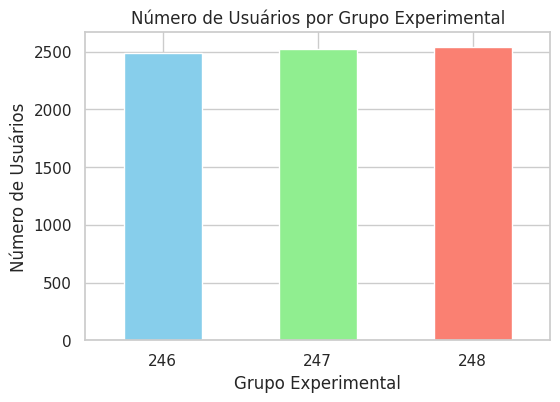

In [32]:
# Gráfico: número de usuários por grupo experimental
users_per_group.plot(kind='bar', figsize=(6,4), color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Número de Usuários por Grupo Experimental')
plt.xlabel('Grupo Experimental')
plt.ylabel('Número de Usuários')
plt.xticks(rotation=0)
plt.show()

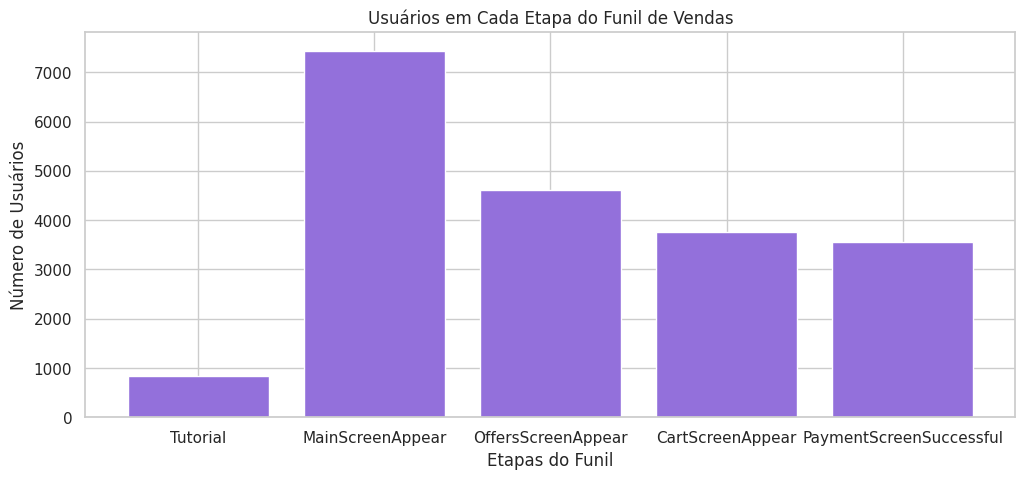

In [35]:
# Gráfico: número de usuários em cada etapa do funil
plt.figure(figsize=(12,5))
plt.bar(users_count.keys(), users_count.values(), color='mediumpurple')
plt.title('Usuários em Cada Etapa do Funil de Vendas')
plt.xlabel('Etapas do Funil')
plt.ylabel('Número de Usuários')
plt.show()

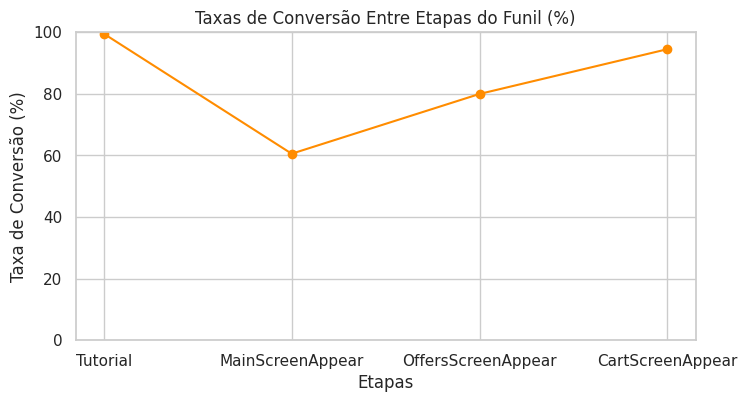

In [36]:
# Gráfico: taxas de conversão entre etapas (em %)
conversions = []
for i in range(len(funnel_events)-1):
    start = funnel_events[i]
    end = funnel_events[i+1]
    if users_count[start] == 0:
        conversions.append(0)
    else:
        conv = len(users_in_funnel[end].intersection(users_in_funnel[start])) / users_count[start]
        conversions.append(conv * 100)

plt.figure(figsize=(8,4))
plt.plot(funnel_events[:-1], conversions, marker='o', color='darkorange')
plt.title('Taxas de Conversão Entre Etapas do Funil (%)')
plt.xlabel('Etapas')
plt.ylabel('Taxa de Conversão (%)')
plt.ylim(0, 100)
plt.grid(True)
plt.show()

# Apresentação Resumida dos Dados

- **Usuários por grupo experimental:** Gráfico mostra que os três grupos (246, 247 e 248) têm uma distribuição razoavelmente equilibrada de usuários.  
- **Usuários por etapa do funil:** Visualizamos a quantidade de usuários que passaram por cada etapa do processo de compra no aplicativo.  
- **Taxas de conversão:** A linha mostra as porcentagens de usuários que avançaram de uma etapa para outra, permitindo identificar onde ocorrem maiores perdas.

# Insights práticos e recomendações baseadas nos dados

# Recomendações e Conselhos para a Empresa

- **Identificação dos pontos críticos no funil:** Observamos que as maiores perdas de usuários ocorrem entre as etapas _OffersScreenAppear_ e _CartScreenAppear_. Isso indica que muitos usuários visualizam as ofertas, mas não avançam para o carrinho, sugerindo possíveis dificuldades na navegação ou falta de interesse nas ofertas apresentadas.

- **Melhorar a experiência nas telas críticas:** Recomendamos simplificar o processo de adicionar itens ao carrinho e destacar benefícios pode ajudar a reduzir a queda.

- **Avaliação do teste A/A/B das fontes:** Os testes indicaram que não há diferenças estatisticamente significativas entre os grupos de controle e o grupo com fontes alteradas. Isso sugere que a mudança de fontes não impacta negativamente o comportamento dos usuários, podendo ser adotada sem riscos.

- **Próximos passos:**  
  - Continuar monitorando o funil de vendas para validar melhorias implementadas.  
  - Testar outras variações no design e funcionalidades que possam incentivar a finalização da compra.  
  - Considerar a segmentação dos usuários para entender diferentes comportamentos e personalizar a experiência.  
  - Avaliar a coleta de feedback direto dos usuários nas etapas críticas para compreender melhor suas dificuldades.
